In [1]:
####################################
# Special code for Jupyter Notebook
####################################
# Show plots in the notebook

%matplotlib inline 
#%matplotlib notebook 

# Automatically reload any packages that changed
#%load_ext autoreload
#%autoreload 2

# Display multiple arguments
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

##################
# Import librarys
##################
# Third party libraries

import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import statistics as stat
import scipy as sp
from scipy import stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import rainflow
import OrcFxAPI


# Course library
work_path = r"C:\Users\snod\OneDrive\CloudStation\DTU\Master in Wind Energy\06 - Master Thesis\19 - python modules"
sys.path.append(work_path)
import pywasp_edu as pw
import stephan_py as st

############################################
# Limit number of rows to print from Pandas
############################################
pd.options.display.max_rows = 40

pi = np.arccos(-1)

# Used in order to embed figures in the text
from IPython.display import Image  

# Load site data

### Assumes 'Generalized Wind Climate' file

In [2]:
# Load 'Generalized Wind Climate' file
filename = r"D:\100 - Project files\01 - Data\01 - Wind\UtsiraNord_GWC.lib"

dirs = ['000','030','060','090','120','150','180','210','240','270','300','330']
gwc_pd = pd.read_csv(filename, header=None, delimiter=r"\s+",names=list(dirs))
gwc_pd.index += 1 

gwc_pd

,000,030,060,090,120,150,180,210,240,270,300,330
1,Global,Wind,Atlas,3.000,(WRF,"3-km)<coordinates>4.306,59.167,0.0</coordinates>",NaN,NaN,NaN,NaN,NaN,NaN
2,5,5,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000,0.030,0.100,0.400,1.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,50.0,100.0,150.000,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8.75,3.28,2.43,3.660,7.69,14.89,12.150,9.200,7.780,8.800,8.310,13.070
...,...,...,...,...,...,...,...,...,...,...,...,...
55,1.979,2.021,2.115,1.596,1.955,2.350,2.119,1.846,1.869,1.975,2.045,2.385
56,5.53,3.97,4.57,6.120,9.52,9.54,8.120,7.510,7.710,7.450,7.260,7.900
57,2.014,1.928,2.131,1.678,2.029,2.338,2.244,1.998,1.975,1.998,2.178,2.443
58,5.82,4.05,4.73,6.680,10.10,10.29,8.690,7.980,8.300,7.960,7.730,8.420


In [3]:
# Divide gwc file into variables

# Frquency per direction
frq_dir = gwc_pd.loc[5]
frq_dir 

# Weibull parameters for roughness length 0m and hubheight 150m
weib_par = gwc_pd.loc[12:13]
weib_par = weib_par.rename({12: 'A', 13: 'k'}).transpose()
weib_par.index = weib_par.index.astype('float64')
weib_par = weib_par.astype('float64')
weib_par = weib_par.reset_index()
weib_par = weib_par.rename(columns={"index": "DIR"})

weib_par

000     8.75
030     3.28
060     2.43
090     3.66
120     7.69
150    14.89
180    12.15
210      9.2
240     7.78
270      8.8
300     8.31
330    13.07
Name: 5, dtype: object

,DIR,A,k
0,0.0,10.18,2.119
1,30.0,6.56,1.799
2,60.0,6.05,1.885
3,90.0,7.30,1.662
4,120.0,13.42,1.998
5,150.0,15.38,2.217
6,180.0,12.72,2.346
7,210.0,11.09,1.990
8,240.0,11.46,1.865
9,270.0,11.39,1.916


In [14]:
def plot_weib(prob, weib, bins):
    """
    Plots a histogram of the wind speed, and the PDFs of the
    Weibull distributions fit using fit_weib.

    Parameters
    ----------
    prob : array
        1-dimensional array of probabilities
    weib : dictionary
        Result from fit_weib function
    """
    # Hard code alpha and loc for 2-parameter Weibull
    loc = 0
    alpha = 1
    

    # Create plot with histogram and PDFs
    fig, ax = plt.subplots(1, 1)

    # Draw PDF of the weibull fits
    dist = stats.exponweib(alpha, weib["k"], loc, weib["A"])
    x = np.linspace(0.0, 25.0, 100)
    ax.plot(x, dist.pdf(x), "r-", lw=2, label="Weibull PDF, A = " + str(round(weib["A"],3)) + ", k = " + str(round(weib["k"],2)))

    # Add Histogram
    spacing = round(prob.index[1] - prob.index[0])

    _= ax.bar(prob.index, prob/spacing, width=1.9)
    ax.set_xticks(prob.index)
    ax.set_ylim([0, round(prob.max()/2.*1.1,1)])

    # Show legend
    ax.legend(loc="upper right", frameon=False)
    plt.show()
    
def bin_centers(bins):
    
    bin_cent = []
    
    for i in range(len(bins)-1):
        
        bin_cent.append((bins[i+1]+bins[i])/2.)
        
    return bin_cent
    
    
def calc_weib_bin_prob(weib, bins):
    
    A = weib["A"]
    k = weib["k"]
    
    bin_cent = bin_centers(bins)
    
    bin_prob = []
    
    for i in range(len(bins)-1):

        bin_prob.append(- np.exp(-A**-k * bins[i+1]**k) + np.exp(-A**-k * bins[i]**k))
          
    return pd.Series(bin_prob, bin_cent)


{'A': 10.18, 'k': 2.119}

4.0     0.126474
6.0     0.164965
8.0     0.173312
10.0    0.155135
12.0    0.121194
14.0    0.083639
16.0    0.051335
18.0    0.028132
20.0    0.013798
22.0    0.006065
24.0    0.002391
dtype: float64

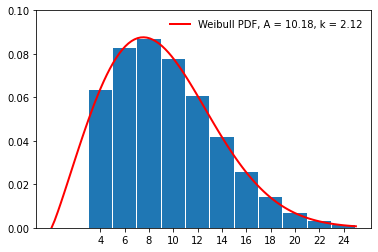

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 6.56, 'k': 1.799}

4.0     0.241461
6.0     0.216420
8.0     0.154056
10.0    0.091641
12.0    0.046696
14.0    0.020681
16.0    0.008038
18.0    0.002761
20.0    0.000842
22.0    0.000229
24.0    0.000056
dtype: float64

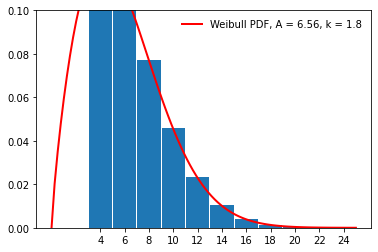

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 6.05, 'k': 1.885}

4.0     0.268520
6.0     0.229416
8.0     0.147354
10.0    0.075057
12.0    0.031102
14.0    0.010640
16.0    0.003034
18.0    0.000726
20.0    0.000147
22.0    0.000025
24.0    0.000004
dtype: float64

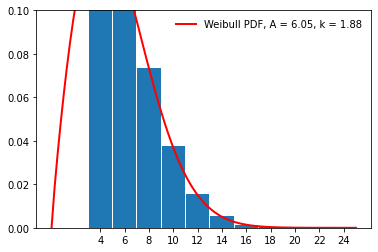

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 7.3, 'k': 1.662}

4.0     0.209285
6.0     0.193240
8.0     0.150870
10.0    0.104129
12.0    0.064936
14.0    0.037065
16.0    0.019532
18.0    0.009561
20.0    0.004368
22.0    0.001869
24.0    0.000752
dtype: float64

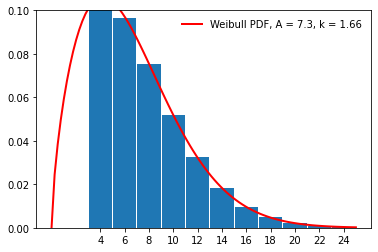

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 13.42, 'k': 1.998}

4.0     0.080962
6.0     0.108625
8.0     0.123974
10.0    0.126933
12.0    0.119385
14.0    0.104459
16.0    0.085673
18.0    0.066185
20.0    0.048321
22.0    0.033421
24.0    0.021936
dtype: float64

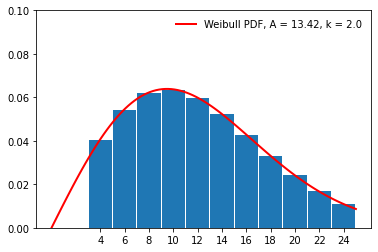

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 15.38, 'k': 2.217}

4.0     0.053149
6.0     0.080743
8.0     0.102533
10.0    0.115758
12.0    0.119334
14.0    0.113875
16.0    0.101367
18.0    0.084559
20.0    0.066293
22.0    0.048932
24.0    0.034043
dtype: float64

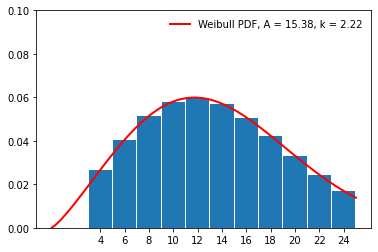

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 12.72, 'k': 2.346}

4.0     0.072645
6.0     0.112490
8.0     0.140312
10.0    0.150308
12.0    0.141968
14.0    0.119689
16.0    0.090608
18.0    0.061763
20.0    0.037947
22.0    0.021013
24.0    0.010481
dtype: float64

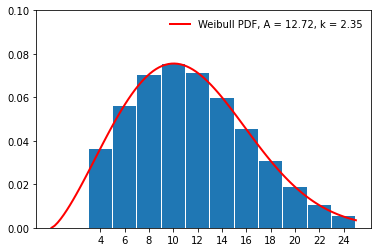

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 11.09, 'k': 1.99}

4.0     0.113810
6.0     0.144578
8.0     0.153289
10.0    0.143019
12.0    0.120229
14.0    0.092225
16.0    0.065044
18.0    0.042385
20.0    0.025605
22.0    0.014374
24.0    0.007513
dtype: float64

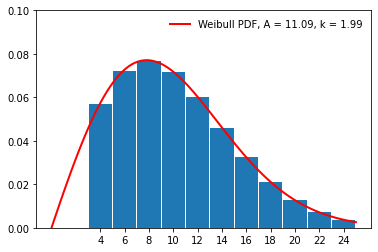

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 11.46, 'k': 1.865}

4.0     0.112933
6.0     0.137086
8.0     0.142376
10.0    0.132805
12.0    0.113749
14.0    0.090560
16.0    0.067524
18.0    0.047393
20.0    0.031426
22.0    0.019740
24.0    0.011771
dtype: float64

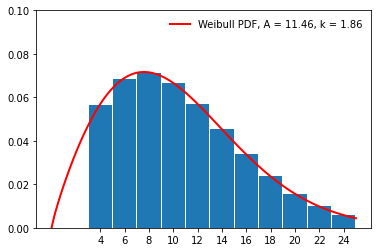

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 11.39, 'k': 1.916}

4.0     0.111910
6.0     0.138710
8.0     0.145751
10.0    0.136543
12.0    0.116679
14.0    0.092085
16.0    0.067633
18.0    0.046463
20.0    0.029963
22.0    0.018186
24.0    0.010409
dtype: float64

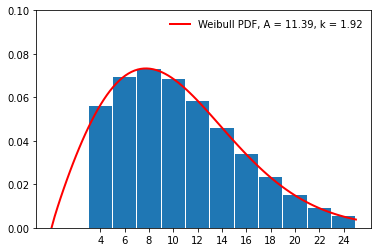

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 10.37, 'k': 1.787}

4.0     0.134541
6.0     0.152890
8.0     0.149200
10.0    0.130920
12.0    0.105533
14.0    0.079093
16.0    0.055534
18.0    0.036721
20.0    0.022955
22.0    0.013604
24.0    0.007662
dtype: float64

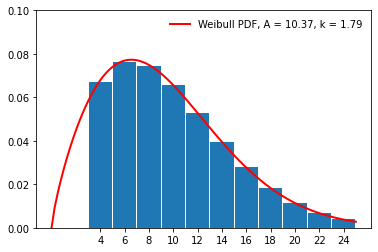

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'A': 11.38, 'k': 2.283}

4.0     0.095299
6.0     0.139062
8.0     0.162152
10.0    0.160575
12.0    0.138444
14.0    0.105133
16.0    0.070714
18.0    0.042237
20.0    0.022424
22.0    0.010582
24.0    0.004436
dtype: float64

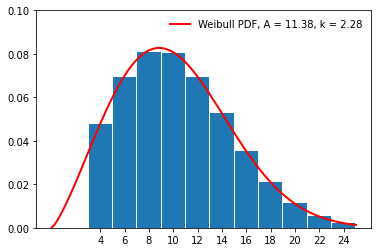

C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,DIR,Freq. [%],A,k,Umean,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0
0,0.0,8.75,10.18,2.119,9.02,0.126474,0.164965,0.173312,0.155135,0.121194,0.0836387,0.0513347,0.028132,0.0137976,0.0060651,0.0023915
1,30.0,3.28,6.56,1.799,5.83,0.241461,0.21642,0.154056,0.0916405,0.0466955,0.020681,0.00803828,0.00276094,0.000842426,0.000229295,5.58628e-05
2,60.0,2.43,6.05,1.885,5.37,0.26852,0.229416,0.147354,0.0750567,0.0311018,0.0106401,0.00303408,0.000726063,0.000146549,2.50482e-05,3.63705e-06
3,90.0,3.66,7.30,1.662,6.52,0.209285,0.19324,0.15087,0.104129,0.0649357,0.0370647,0.0195316,0.00956087,0.00436793,0.00186932,0.000751683
4,120.0,7.69,13.42,1.998,11.89,0.0809616,0.108625,0.123974,0.126933,0.119385,0.104459,0.0856732,0.0661852,0.0483215,0.0334207,0.0219355
5,150.0,14.89,15.38,2.217,13.62,0.0531492,0.080743,0.102533,0.115758,0.119334,0.113875,0.101367,0.0845594,0.0662928,0.0489318,0.0340429
6,180.0,12.15,12.72,2.346,11.27,0.0726452,0.11249,0.140312,0.150308,0.141968,0.119689,0.0906077,0.0617631,0.037947,0.0210134,0.0104809
7,210.0,9.2,11.09,1.990,9.83,0.11381,0.144578,0.153289,0.143019,0.120229,0.0922253,0.065044,0.0423849,0.0256049,0.0143745,0.00751271
8,240.0,7.78,11.46,1.865,10.18,0.112933,0.137086,0.142376,0.132805,0.113749,0.0905599,0.067524,0.0473934,0.031426,0.01974,0.0117706
9,270.0,8.8,11.39,1.916,10.1,0.11191,0.13871,0.145751,0.136543,0.116679,0.0920846,0.0676333,0.0464634,0.029963,0.0181856,0.010409


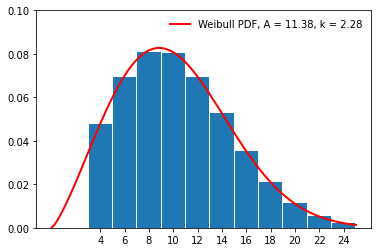

In [15]:
# Plot PDF's for weibull parameters extracted from Global Wind Atlas file
n_bins = 11
bin_def = np.linspace(3,25,n_bins+1)

columns = pd.concat([pd.Series(['DIR','Freq. [%]', 'A', 'k', 'Umean']), pd.Series(bin_centers(bin_def))],axis = 0)

prob_df = pd.DataFrame(columns=columns)
prob_df['Freq. [%]'] = frq_dir.to_list()
prob_df['DIR'] = weib_par['DIR']
prob_df['A'] = weib_par['A']
prob_df['k'] = weib_par['k']

#prob_df

for i in range (len(frq_dir.index)):
    
    # Plot histogram and weibull distribution
    weib = {"A": weib_par['A'].iloc[i], "k": weib_par['k'].iloc[i]}
    weib

    bin_prob = calc_weib_bin_prob(weib, bin_def)
    bin_prob


    plot_weib(bin_prob, weib, bin_def)

    prob_df.iloc[[i], 5:16] = bin_prob.to_list()
    
    # Calculate mean wind speed
    prob_df['Umean'].iloc[i] = round(st.calc_functions.WeibullMean(weib),2)

prob_df

weib = {"A": weib_par['A'].iloc[-1], "k": weib_par['k'].iloc[-1]}
bin_prob = calc_weib_bin_prob(weib, bin_def)
plot_weib(bin_prob, weib, bin_def)
    

In [13]:
# calculate omnidirectional values
# insert row for values
prob_df = prob_df.append(pd.Series(), ignore_index=True)
prob_df['DIR'].iloc[-1] = 'Omni'
omni_vals = np.zeros(n_bins)

for i in range (len(frq_dir.index)):

    omni_vals = omni_vals + float(prob_df['Freq. [%]'].iloc[i])/100. * prob_df.iloc[[i], 5:16].values

omni_vals = omni_vals[0]
# insert omni vals in dataframe
prob_df.iloc[[-1], 5:16] = omni_vals
print(omni_vals.sum())

# Check sum of frequencies
prob_df['Freq. [%]'].iloc[-1] = np.sum(prob_df['Freq. [%]'].iloc[0:12].astype(float))

prob_df

0.9128699989242337


<ipython-input-13-84755fbe9d94>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prob_df = prob_df.append(pd.Series(), ignore_index=True)
C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,DIR,Freq. [%],A,k,Umean,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0
0,0,8.75,10.18,2.119,9.02,0.126474,0.164965,0.173312,0.155135,0.121194,0.0836387,0.0513347,0.028132,0.0137976,0.0060651,0.0023915
1,30,3.28,6.56,1.799,5.83,0.241461,0.21642,0.154056,0.0916405,0.0466955,0.020681,0.00803828,0.00276094,0.000842426,0.000229295,5.58628e-05
2,60,2.43,6.05,1.885,5.37,0.26852,0.229416,0.147354,0.0750567,0.0311018,0.0106401,0.00303408,0.000726063,0.000146549,2.50482e-05,3.63705e-06
3,90,3.66,7.30,1.662,6.52,0.209285,0.19324,0.15087,0.104129,0.0649357,0.0370647,0.0195316,0.00956087,0.00436793,0.00186932,0.000751683
4,120,7.69,13.42,1.998,11.89,0.0809616,0.108625,0.123974,0.126933,0.119385,0.104459,0.0856732,0.0661852,0.0483215,0.0334207,0.0219355
5,150,14.89,15.38,2.217,13.62,0.0531492,0.080743,0.102533,0.115758,0.119334,0.113875,0.101367,0.0845594,0.0662928,0.0489318,0.0340429
6,180,12.15,12.72,2.346,11.27,0.0726452,0.11249,0.140312,0.150308,0.141968,0.119689,0.0906077,0.0617631,0.037947,0.0210134,0.0104809
7,210,9.2,11.09,1.990,9.83,0.11381,0.144578,0.153289,0.143019,0.120229,0.0922253,0.065044,0.0423849,0.0256049,0.0143745,0.00751271
8,240,7.78,11.46,1.865,10.18,0.112933,0.137086,0.142376,0.132805,0.113749,0.0905599,0.067524,0.0473934,0.031426,0.01974,0.0117706
9,270,8.8,11.39,1.916,10.1,0.11191,0.13871,0.145751,0.136543,0.116679,0.0920846,0.0676333,0.0464634,0.029963,0.0181856,0.010409


In [7]:
# Fit weibull to probabilities
bin_cent = bin_centers(bin_def)

data = np.array([])

for i in range(len(omni_vals)):
    
    data = np.concatenate((data, bin_cent[i] * np.ones(round(omni_vals[i]*10000))))

weib_new = pw.weibull.fit_weib(data)

print(weib_new)

prob_df['A'].iloc[-1] = weib_new['A']
prob_df['k'].iloc[-1] = weib_new['k']
prob_df['Umean'].iloc[-1] = round(st.calc_functions.WeibullMean(weib_new),2)
prob_df

{'A': 12.098663910646197, 'k': 2.2852355173277337}


C:\Users\snod\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,DIR,Freq. [%],A,k,Umean,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0
0,0,8.75,10.180000,2.119000,9.02,0.126474,0.164965,0.173312,0.155135,0.121194,0.0836387,0.0513347,0.028132,0.0137976,0.0060651,0.0023915
1,30,3.28,6.560000,1.799000,5.83,0.241461,0.21642,0.154056,0.0916405,0.0466955,0.020681,0.00803828,0.00276094,0.000842426,0.000229295,5.58628e-05
2,60,2.43,6.050000,1.885000,5.37,0.26852,0.229416,0.147354,0.0750567,0.0311018,0.0106401,0.00303408,0.000726063,0.000146549,2.50482e-05,3.63705e-06
3,90,3.66,7.300000,1.662000,6.52,0.209285,0.19324,0.15087,0.104129,0.0649357,0.0370647,0.0195316,0.00956087,0.00436793,0.00186932,0.000751683
4,120,7.69,13.420000,1.998000,11.89,0.0809616,0.108625,0.123974,0.126933,0.119385,0.104459,0.0856732,0.0661852,0.0483215,0.0334207,0.0219355
5,150,14.89,15.380000,2.217000,13.62,0.0531492,0.080743,0.102533,0.115758,0.119334,0.113875,0.101367,0.0845594,0.0662928,0.0489318,0.0340429
6,180,12.15,12.720000,2.346000,11.27,0.0726452,0.11249,0.140312,0.150308,0.141968,0.119689,0.0906077,0.0617631,0.037947,0.0210134,0.0104809
7,210,9.2,11.090000,1.990000,9.83,0.11381,0.144578,0.153289,0.143019,0.120229,0.0922253,0.065044,0.0423849,0.0256049,0.0143745,0.00751271
8,240,7.78,11.460000,1.865000,10.18,0.112933,0.137086,0.142376,0.132805,0.113749,0.0905599,0.067524,0.0473934,0.031426,0.01974,0.0117706
9,270,8.8,11.390000,1.916000,10.1,0.11191,0.13871,0.145751,0.136543,0.116679,0.0920846,0.0676333,0.0464634,0.029963,0.0181856,0.010409


In [8]:
# Save to csv
if 0:
    file_name = r"weibull_prob.csv"
    prob_df.to_csv(file_name)

Text(0.5, 1.0, 'Mean wind speeds [m/s]')

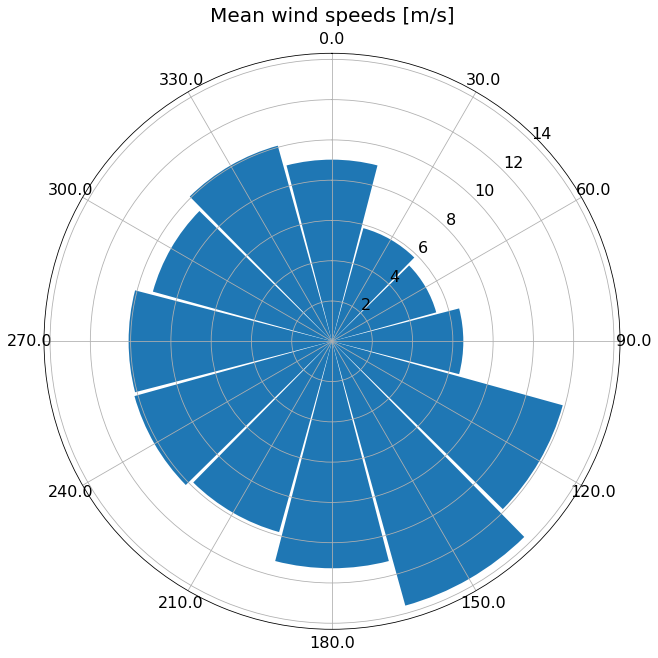

In [9]:
# Plot mean wind speed per sector

Umean_ser = prob_df['Umean']
Umean_ser.index = prob_df['DIR']
Umean_ser = Umean_ser.drop(labels = ['Omni']) 
Umean_ser.index = Umean_ser.index.astype('float')
ax = pw.plot_rose(Umean_ser)  # rose plot sector-wise mean wind speed / Weibull 'A'
ax.set_title("Mean wind speeds [m/s]", va='bottom')

ax.title.set_fontsize(20)
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
